In [1]:
import keras
import keras.backend as K
from keras.datasets import mnist
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute, TimeDistributed, Bidirectional
from keras.layers import Concatenate, Reshape, Conv2DTranspose, Embedding, Multiply, Activation

from functools import partial

from collections import defaultdict

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

class MySequence :
    def __init__(self) :
        self.dummy = 1

keras.utils.Sequence = MySequence

import isolearn.io as isoio
import isolearn.keras as isol

import matplotlib.pyplot as plt

from sequence_logo_helper import dna_letter_at, plot_dna_logo

import deeplift
from deeplift.conversion import kerasapi_conversion as kc
from deeplift.util import get_integrated_gradients_function


Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36_deeplift/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/anaconda3/envs/tensorflow_p36_deeplift/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/anaconda3/envs/tensorflow_p36_deeplift/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dt

In [2]:
#Define dataset/experiment name
dataset_name = "apa_doubledope"

#Load cached dataframe
cached_dict = pickle.load(open('apa_doubledope_cached_set.pickle', 'rb'))
data_df = cached_dict['data_df']

print("len(data_df) = " + str(len(data_df)) + " (loaded)")


len(data_df) = 34748 (loaded)


In [3]:
#Make generators

valid_set_size = 0.05
test_set_size = 0.05

batch_size = 32

#Generate training and test set indexes
data_index = np.arange(len(data_df), dtype=np.int)

train_index = data_index[:-int(len(data_df) * (valid_set_size + test_set_size))]
valid_index = data_index[train_index.shape[0]:-int(len(data_df) * test_set_size)]
test_index = data_index[train_index.shape[0] + valid_index.shape[0]:]

print('Training set size = ' + str(train_index.shape[0]))
print('Validation set size = ' + str(valid_index.shape[0]))
print('Test set size = ' + str(test_index.shape[0]))


data_gens = {
    gen_id : isol.DataGenerator(
        idx,
        {'df' : data_df},
        batch_size=batch_size,
        inputs = [
            {
                'id' : 'seq',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : isol.SequenceExtractor('padded_seq', start_pos=180, end_pos=180 + 205),
                'encoder' : isol.OneHotEncoder(seq_length=205),
                'dim' : (1, 205, 4),
                'sparsify' : False
            }
        ],
        outputs = [
            {
                'id' : 'hairpin',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : lambda row, index: row['proximal_usage'],
                'transformer' : lambda t: t,
                'dim' : (1,),
                'sparsify' : False
            }
        ],
        randomizers = [],
        shuffle = True if gen_id == 'train' else False
    ) for gen_id, idx in [('all', data_index), ('train', train_index), ('valid', valid_index), ('test', test_index)]
}


Training set size = 31274
Validation set size = 1737
Test set size = 1737


In [4]:
#Load data matrices

x_train = np.concatenate([data_gens['train'][i][0][0] for i in range(len(data_gens['train']))], axis=0)
x_test = np.concatenate([data_gens['test'][i][0][0] for i in range(len(data_gens['test']))], axis=0)

y_train = np.concatenate([data_gens['train'][i][1][0] for i in range(len(data_gens['train']))], axis=0)
y_test = np.concatenate([data_gens['test'][i][1][0] for i in range(len(data_gens['test']))], axis=0)

print("x_train.shape = " + str(x_train.shape))
print("x_test.shape = " + str(x_test.shape))

print("y_train.shape = " + str(y_train.shape))
print("y_test.shape = " + str(y_test.shape))


x_train.shape = (31264, 1, 205, 4)
x_test.shape = (1728, 1, 205, 4)
y_train.shape = (31264, 1)
y_test.shape = (1728, 1)


In [5]:
#Define sequence template (APA Doubledope sublibrary)

sequence_template = 'CTTCCGATCTNNNNNNNNNNNNNNNNNNNNCATTACTCGCATCCANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCAGCCAATTAAGCCNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCTAC'

sequence_mask = np.array([1 if sequence_template[j] == 'N' else 0 for j in range(len(sequence_template))])


In [6]:
#Visualize background sequence distribution

pseudo_count = 1.0

x_mean = (np.sum(x_train, axis=(0, 1)) + pseudo_count) / (x_train.shape[0] + 4. * pseudo_count)
x_mean_logits = np.log(x_mean / (1. - x_mean))


In [12]:
#APARENT parameters
seq_input_shape = (205, 4, 1)
lib_input_shape = (13,)
distal_pas_shape = (1,)
num_outputs_iso = 1
num_outputs_cut = 206

#Shared model definition
layer_1 = Conv2D(96, (8, 4), padding='valid', activation='relu', name='conv2d_1')
layer_1_pool = MaxPooling2D(pool_size=(2, 1), name='max_pooling2d_1')
layer_2 = Conv2D(128, (6, 1), padding='valid', activation='relu', name='conv2d_2')
layer_dense = Dense(256, activation='relu', name='dense_1')
layer_drop = Dropout(0.2)

def shared_model(seq_input, distal_pas_input) :
    return layer_drop(
        layer_dense(
            Concatenate()([
                Flatten()(
                    layer_2(
                        layer_1_pool(
                            layer_1(
                                seq_input
                            )
                        )
                    )
                ),
                distal_pas_input
            ])
        )
    )

#Inputs
seq_input = Input(name="seq_input", shape=seq_input_shape)
lib_input = Input(name="lib_input", shape=lib_input_shape)
distal_pas_input = Input(name="distal_pas_input", shape=distal_pas_shape)

#permute_layer = Lambda(lambda x: K.permute_dimensions(x, (0, 2, 3, 1)))

plasmid_out_shared = Concatenate()([shared_model(seq_input, distal_pas_input), lib_input])

plasmid_out_cut = Dense(num_outputs_cut, activation='linear', kernel_initializer='zeros', name='dense_2')(plasmid_out_shared)
plasmid_out_iso = Dense(num_outputs_iso, activation='linear', kernel_initializer='zeros', name="dense_3")(plasmid_out_shared)

predictor_temp = Model(
    inputs=[
        seq_input,
        lib_input,
        distal_pas_input
    ],
    outputs=[
        plasmid_out_iso,
        plasmid_out_cut
    ]
)

predictor_temp.load_weights('../../../aparent/saved_models/aparent_plasmid_iso_cut_distalpas_all_libs_no_sampleweights_sgd.h5')

original_predictor = Model(
    inputs=predictor_temp.inputs,
    outputs=[
        predictor_temp.outputs[0]
    ]
)

original_predictor.trainable = False

original_predictor.compile(
    optimizer=keras.optimizers.SGD(lr=0.1),
    loss='mean_squared_error'
)


In [18]:
#Inflate APARENT model without concatenate layers (to fix compatibility issues with DeepLIFT package)

layer_1 = Conv2D(96, (8, 4), padding='valid', activation='relu', name='conv2d_1_copy')
layer_1_pool = MaxPooling2D(pool_size=(2, 1), name='max_pooling2d_1_copy')
layer_2 = Conv2D(128, (6, 1), padding='valid', activation='relu', name='conv2d_2_copy')
layer_dense = Dense(256, activation='relu', name='dense_1_copy')
layer_drop = Dropout(0.2)

def shared_model(seq_input) :
    return layer_drop(
        layer_dense(
            Flatten()(
                layer_2(
                    layer_1_pool(
                        layer_1(
                            seq_input
                        )
                    )
                )
            )
        )
    )

#Inputs
seq_input = Input(name="seq_input_copy", shape=seq_input_shape)

plasmid_out_shared = shared_model(seq_input)

plasmid_out_iso = Dense(num_outputs_iso, activation='linear', kernel_initializer='zeros', name="dense_3_copy")(plasmid_out_shared)

predictor = Model(
    inputs=[
        seq_input
    ],
    outputs=[
        plasmid_out_iso
    ]
)

predictor.trainable = False

predictor.compile(
    optimizer=keras.optimizers.SGD(lr=0.1),
    loss='mean_squared_error'
)


In [28]:
#Transfer weights

predictor.get_layer("conv2d_1_copy").set_weights(original_predictor.get_layer("conv2d_1").get_weights())
predictor.get_layer("conv2d_2_copy").set_weights(original_predictor.get_layer("conv2d_2").get_weights())

dense_1_w_orig = original_predictor.get_layer("dense_1").get_weights()[0]
dense_1_b_orig = original_predictor.get_layer("dense_1").get_weights()[1]

dense_1_w = dense_1_w_orig[:-1, :]
dense_1_b = dense_1_b_orig[:] + dense_1_w_orig[-1, :]

predictor.get_layer("dense_1_copy").set_weights([dense_1_w, dense_1_b])

dense_3_w_orig = original_predictor.get_layer("dense_3").get_weights()[0]
dense_3_b_orig = original_predictor.get_layer("dense_3").get_weights()[1]

dense_3_w = dense_3_w_orig[:-13, :]
dense_3_b = dense_3_b_orig[:] + dense_3_w_orig[-13 + 4, :]

predictor.get_layer("dense_3_copy").set_weights([dense_3_w, dense_3_b])

predictor.compile(
    optimizer=keras.optimizers.SGD(lr=0.1),
    loss='mean_squared_error'
)


In [30]:
#Save deeplift-version of model

predictor.save("saved_models/aparent_plasmid_iso_cut_distalpas_all_libs_no_sampleweights_sgd_deeplift.h5")


In [33]:
#Specify deeplift attribution models

predictor_path = "saved_models/aparent_plasmid_iso_cut_distalpas_all_libs_no_sampleweights_sgd_deeplift.h5"

gradient_model = kc.convert_model_from_saved_files(
    predictor_path,
    nonlinear_mxts_mode=deeplift.layers.NonlinearMxtsMode.Gradient
)
gradient_func = gradient_model.get_target_contribs_func(find_scores_layer_name='seq_input_copy_0', pre_activation_target_layer_name='dense_3_copy_0')

guided_backprop_model = kc.convert_model_from_saved_files(
    predictor_path,
    nonlinear_mxts_mode=deeplift.layers.NonlinearMxtsMode.GuidedBackprop
)
guided_backprop_func = guided_backprop_model.get_target_contribs_func(find_scores_layer_name='seq_input_copy_0', pre_activation_target_layer_name='dense_3_copy_0')

rescale_model = kc.convert_model_from_saved_files(
    predictor_path,
    nonlinear_mxts_mode=deeplift.layers.NonlinearMxtsMode.Rescale
)
rescale_func = rescale_model.get_target_contribs_func(find_scores_layer_name='seq_input_copy_0', pre_activation_target_layer_name='dense_3_copy_0')

revealcancel_model = kc.convert_model_from_saved_files(
    predictor_path,
    nonlinear_mxts_mode=deeplift.layers.NonlinearMxtsMode.RevealCancel
)
revealcancel_func = revealcancel_model.get_target_contribs_func(find_scores_layer_name='seq_input_copy_0', pre_activation_target_layer_name='dense_3_copy_0')

integrated_gradients_func = get_integrated_gradients_function(gradient_func, 10)

attribution_suffixes = [
    'gradient',
    'guided_backprop',
    'rescale',
    'revealcancel',
    'integrated_gradients'
]

attribution_funcs = [
    gradient_func,
    guided_backprop_func,
    rescale_func,
    revealcancel_func,
    integrated_gradients_func
]


nonlinear_mxts_mode is set to: Gradient
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
TARGET LAYER SET TO dense_3_copy_0
nonlinear_mxts_mode is set to: GuidedBackprop
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
TARGET LAYER SET TO dense_3_copy_0
nonlinear_mxts_mode is set to: Rescale
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
TARGET LAYER SET TO dense_3_copy_0
nonlinear_mxts_mode is set to: RevealCancel
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
TARGET LAYER SET TO dense_3_copy_0


In [38]:
#Tile the ref background to same shape as test set

x_mean_tiled_test = np.tile(np.expand_dims(np.expand_dims(x_mean, axis=0), axis=-1), (x_test.shape[0], 1, 1, 1))


In [34]:
#Gradient saliency/backprop visualization

import matplotlib.collections as collections
import operator
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

def plot_importance_scores(importance_scores, ref_seq, figsize=(12, 2), score_clip=None, sequence_template='', plot_start=0, plot_end=96) :

    end_pos = ref_seq.find("#")
    
    fig = plt.figure(figsize=figsize)
    
    ax = plt.gca()
    
    if score_clip is not None :
        importance_scores = np.clip(np.copy(importance_scores), -score_clip, score_clip)
    
    max_score = np.max(np.sum(importance_scores[:, :], axis=0)) + 0.01

    for i in range(0, len(ref_seq)) :
        mutability_score = np.sum(importance_scores[:, i])
        dna_letter_at(ref_seq[i], i + 0.5, 0, mutability_score, ax)

    plt.sca(ax)
    plt.xlim((0, len(ref_seq)))
    plt.ylim((0, max_score))
    plt.axis('off')
    plt.yticks([0.0, max_score], [0.0, max_score], fontsize=16)
    
    plt.tight_layout()
    
    plt.show()


Attribution method = 'gradient'
Done 0
Test sequence 0:


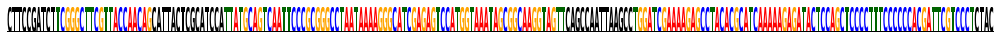

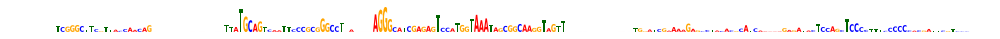

Test sequence 1:


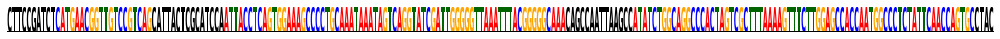

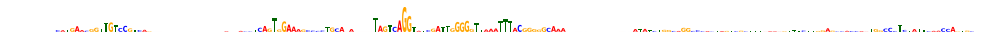

Test sequence 2:


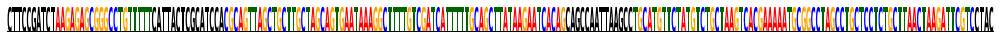

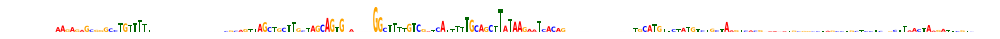

Test sequence 3:


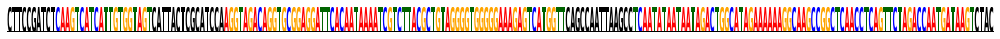

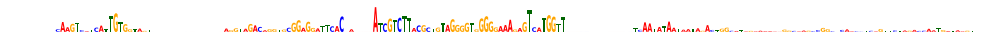

Test sequence 4:


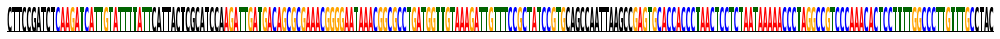

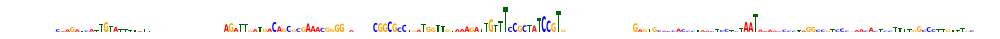

Test sequence 5:


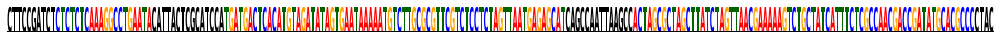

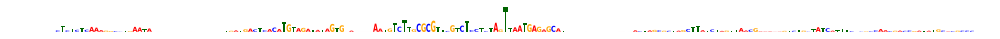

Test sequence 6:


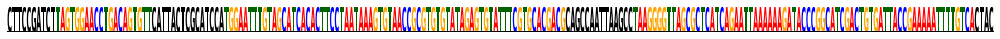

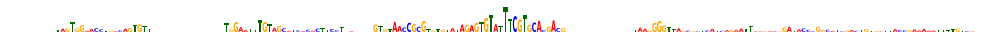

Test sequence 7:


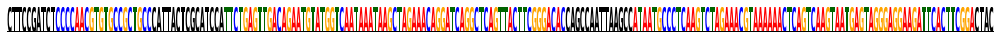

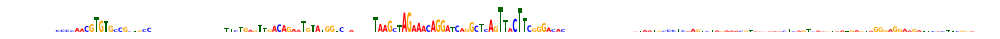

Test sequence 8:


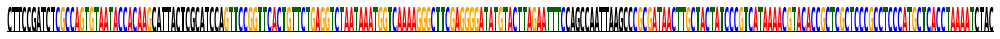

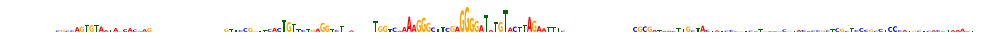

Test sequence 9:


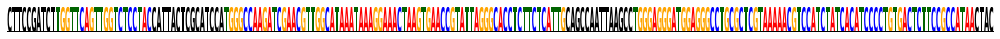

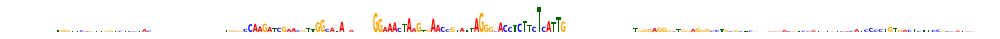

Attribution method = 'guided_backprop'
Done 0
Test sequence 0:


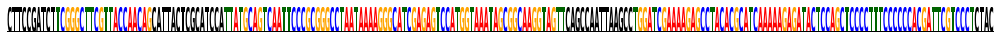

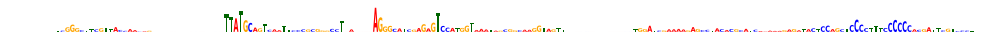

Test sequence 1:


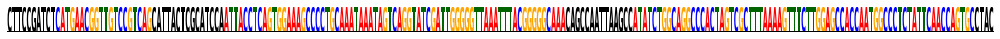

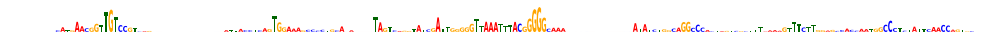

Test sequence 2:


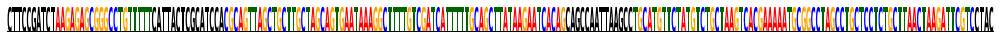

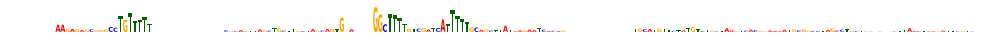

Test sequence 3:


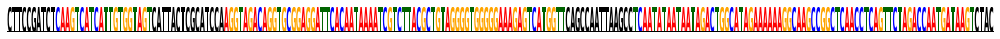

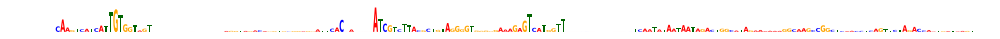

Test sequence 4:


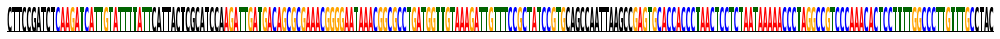

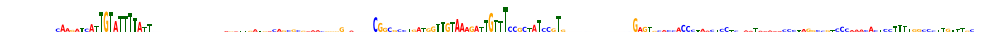

Test sequence 5:


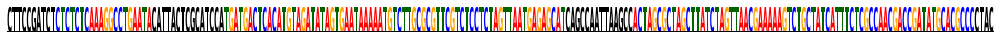

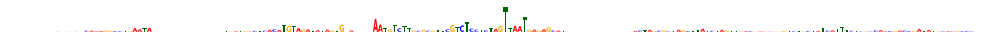

Test sequence 6:


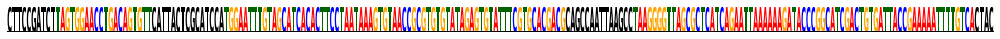

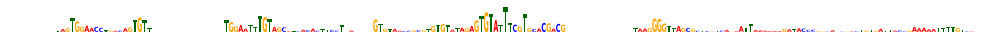

Test sequence 7:


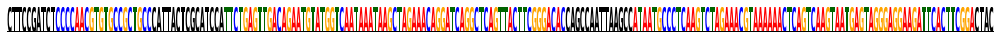

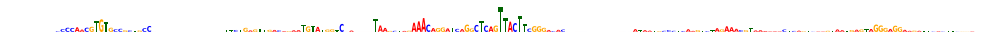

Test sequence 8:


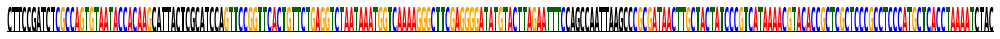

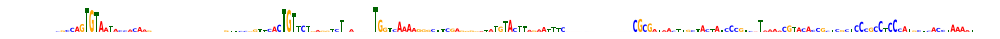

Test sequence 9:


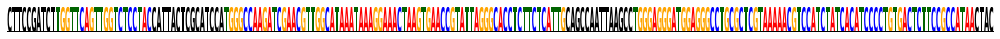

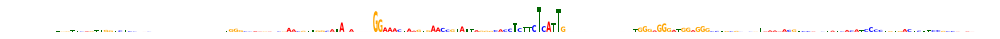

Attribution method = 'rescale'
Done 0
Test sequence 0:


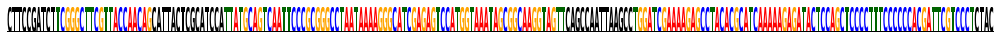

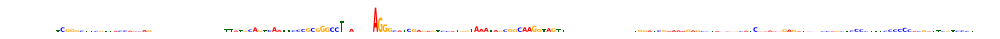

Test sequence 1:


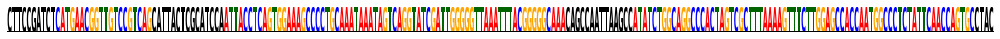

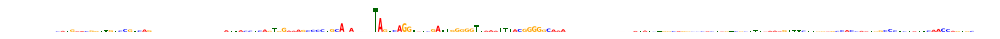

Test sequence 2:


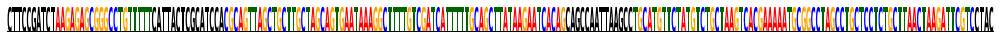

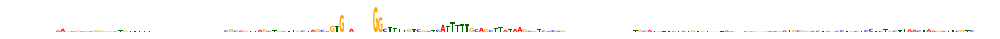

Test sequence 3:


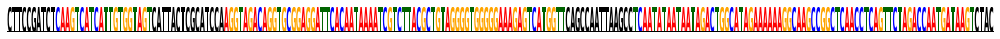

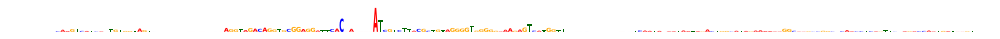

Test sequence 4:


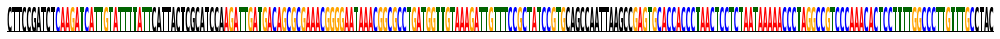

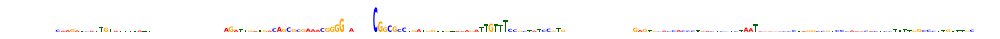

Test sequence 5:


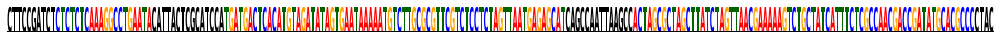

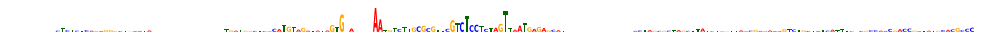

Test sequence 6:


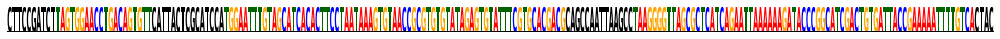

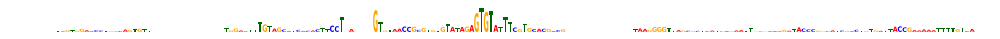

Test sequence 7:


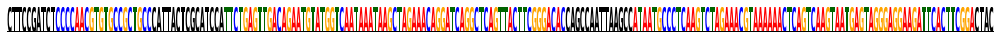

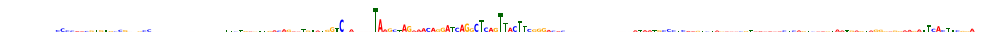

Test sequence 8:


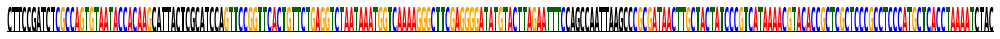

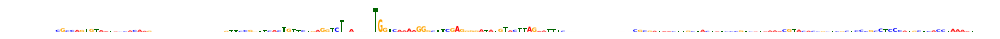

Test sequence 9:


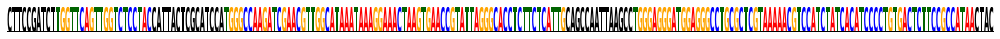

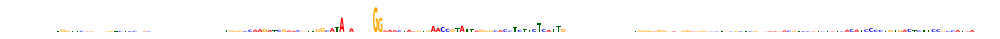

Attribution method = 'revealcancel'
Done 0
Test sequence 0:


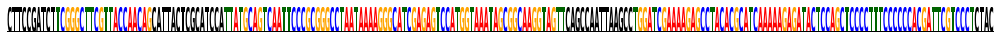

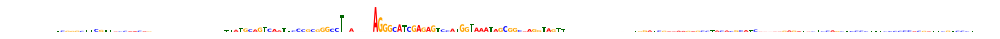

Test sequence 1:


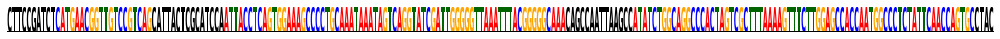

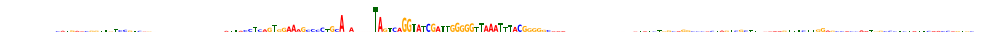

Test sequence 2:


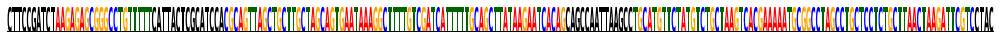

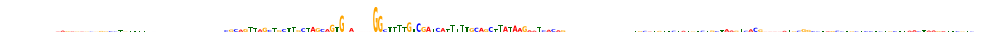

Test sequence 3:


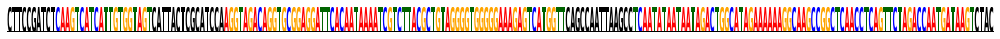

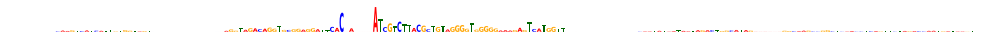

Test sequence 4:


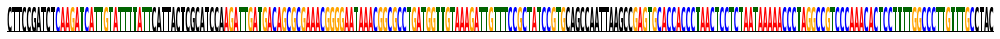

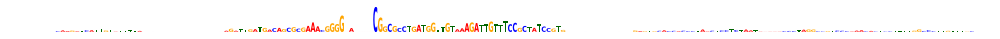

Test sequence 5:


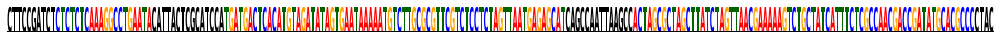

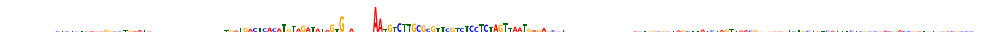

Test sequence 6:


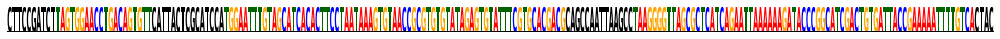

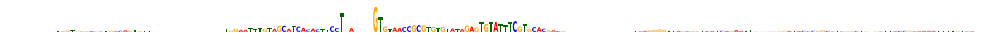

Test sequence 7:


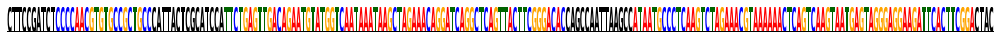

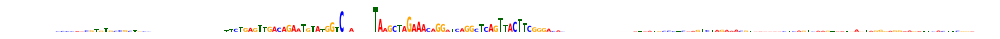

Test sequence 8:


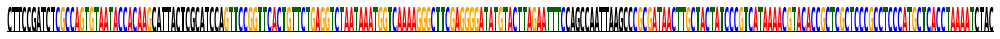

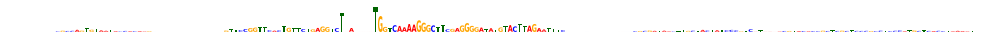

Test sequence 9:


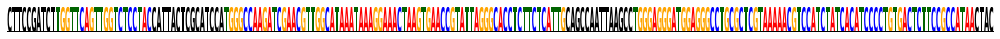

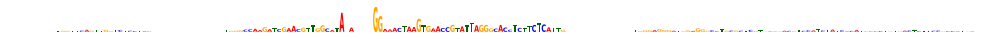

Attribution method = 'integrated_gradients'
Done 0
Done 4000
Done 8000
Done 12000
Done 16000
Test sequence 0:


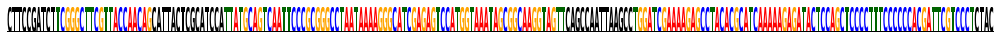

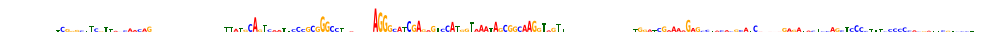

Test sequence 1:


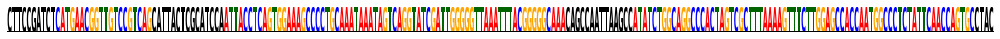

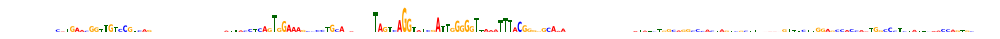

Test sequence 2:


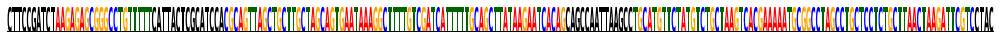

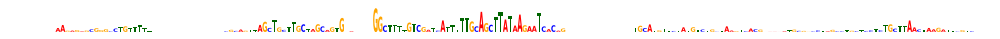

Test sequence 3:


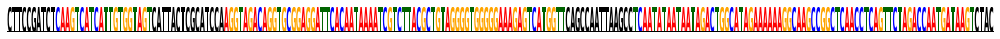

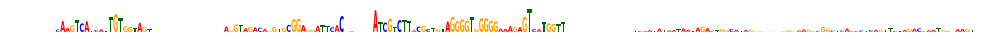

Test sequence 4:


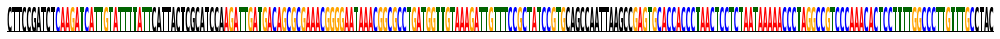

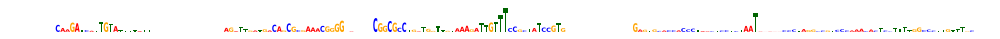

Test sequence 5:


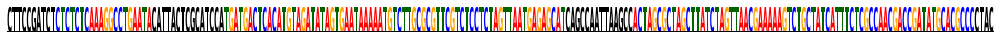

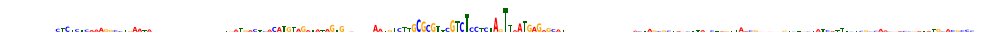

Test sequence 6:


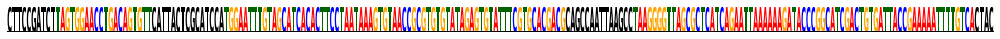

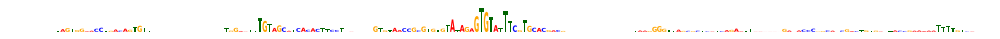

Test sequence 7:


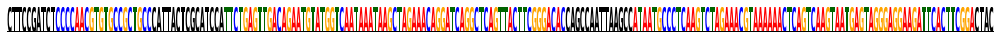

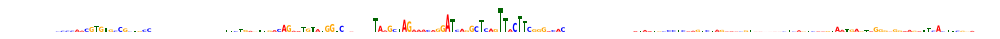

Test sequence 8:


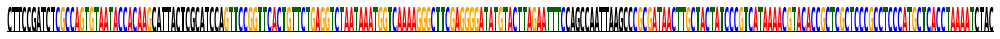

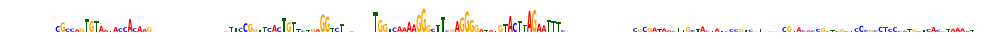

Test sequence 9:


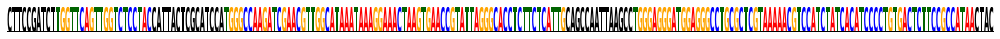

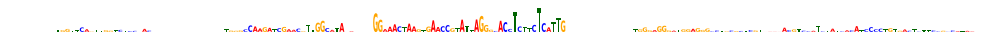

In [56]:
#Run attribution methods

encoder = isol.OneHotEncoder(205)

score_clip = 1.5

for attr_suffix, attr_func in zip(attribution_suffixes, attribution_funcs) :
    
    print("Attribution method = '" + attr_suffix + "'")

    importance_scores_test = np.array(attr_func(task_idx=0, input_data_list=[np.transpose(x_test, (0, 2, 3, 1))], input_references_list=[x_mean_tiled_test], batch_size=32, progress_update=1000))
    importance_scores_test = np.transpose(importance_scores_test, (0, 3, 1, 2))
    
    importance_scores_test_signed = np.copy(importance_scores_test)
    importance_scores_test = np.abs(importance_scores_test)
    
    for plot_i in range(0, 10) :

        print("Test sequence " + str(plot_i) + ":")

        plot_dna_logo(x_test[plot_i, 0, :, :], sequence_template=sequence_template, plot_sequence_template=True, figsize=(14, 0.65), plot_start=0, plot_end=205)
        plot_importance_scores(importance_scores_test[plot_i, 0, :, :].T, encoder.decode(x_test[plot_i, 0, :, :]), figsize=(14, 0.65), score_clip=score_clip, sequence_template=sequence_template, plot_start=0, plot_end=205)

        #Save predicted importance scores

        model_name = "deeplift_" + dataset_name + "_method_" + attr_suffix

        np.save(model_name + "_importance_scores_test", importance_scores_test)
